In [10]:
import  lib_Experimentum    as      Exp
from    Alessandria         import  *
from    Models              import  S_2_Generate, S_Dynamical_Form_Factor_2, S_Dynamical_Form_Factor_0, S_0_Generate

import pandas as pd
import  numpy               as      np
from    scipy.io            import  loadmat

from    matplotlib.pyplot   import  plot
import  matplotlib.pyplot   as      plt


import  time
now_path        =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
VIPA_filename       =   'NO_ARS_13_02_VIPA_not_sat.tif'

syg_kwargs          =   {'height': 20, 'distance': 20, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':70, 'width': 1}
syg_kwargs_brill    =  {'height': 20, 'distance': 20, 'width': 3.}
VIPA_treshold       =   6
sat_height          =   50000
sat_width           =   13.5

cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')

ATTENZIONE funzione da aggiornare



ATTENZIONE guarda Get_VIPA_mat


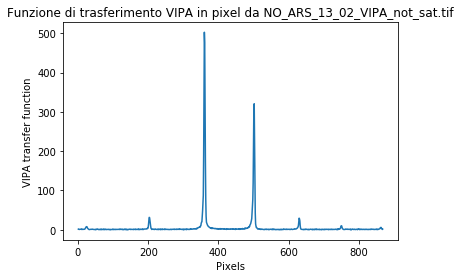

Lo spettro è bono
Lo spettro ha 4 picchi


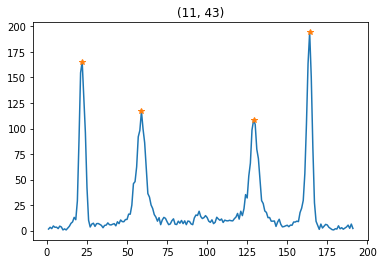

In [11]:
#0) importo dati e inizializzo oggetti
i   =   11
j   =   43
y    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')[i][j]
Data    =   Exp.Spectrum(name = str((i,j)))
Data.Get_Spectrum(y = np.resize(y, np.max(y.shape)), offset = 183., cut = False, cut_range = (10, 175))
Data.Get_Spectrum_Peaks(**syg_kwargs)
Data.Get_VIPA_tif(VIPA_filename, now_path, fig = 'VIPA_img', save_path = now_path)

plt.figure()
plt.plot(Data.x, Data.y)
plt.plot(Data.x[Data.peaks[0]], Data.y[Data.peaks[0]], '*')
plt.title(str((i,j)))

check = Data.Check_Spectrum(saturation_height = sat_height, saturation_width = sat_width)

if      check == 1  : nature    = 'saturo'
elif    check == 2  : nature    = 'brillouin_higher'
elif    check == 3  : nature    = 'invisible'
else:                 nature    = 'bono'
print('Lo spettro è '+nature)
print('Lo spettro ha {} picchi'.format(Data.n_peaks))

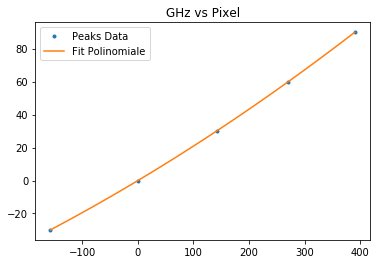

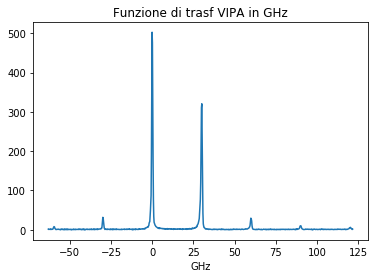

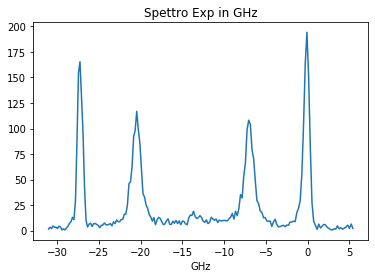



Ho stimato 12 parametri iniziali per il fit che andrai a fare

Co  = 1.000 

Omega  = 6.706 

Gamma  = 0.626 

Delta  = 0.626 

tau  = 10.000 

delta_width  = 0.500 

delta_amplitude  = 0.100 

A  =  nan 

mu  =  nan 

sigma  =  nan 

shift  = 0.000 

offset  = 19.761 

Ho stimato i parametri della gaussiana come A = 622.64	mu  = 10.85	sigma = 16.71
E li ho aggiunti ai parametri iniziali per il fit. Ora conosco 12 parametri su 12 



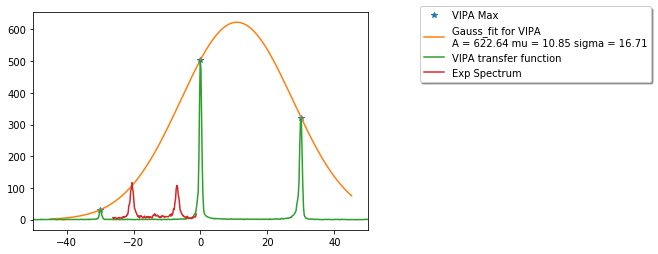

Text(0.5, 1.0, 'Spectrum ready for fit (11, 43)')

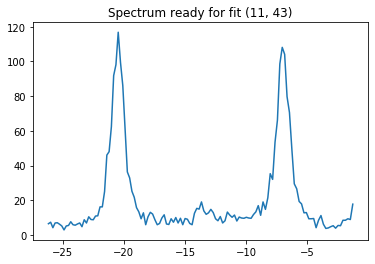

In [12]:
#1) Operazioni di modifica Spettro

Data.How_Many_Peaks_To_VIPA(treshold = VIPA_treshold, **syg_kwargs_VIPA)
Data.Fit_Pixel2GHz(fig = True)
Data.VIPA_Pix2GHz(fig = True)

if nature == 'brillouin_higher':

    Data.Spectrum_Pix2GHz(align = False)

Data.Spectrum_Pix2GHz(fig = True)

if nature == 'brillouin_higher':  

    Data.Get_Spectrum_Peaks(**syg_kwargs_brill)
    Data.Get_Spectrum_4_Peaks_by_Order()

    # se è Brillouin highest dx
    if (Data.y[Data.peaks['peaks_idx'][2]] > Data.y[Data.peaks['peaks_idx'][1]]) & (Data.y[Data.peaks['peaks_idx'][2]] > Data.y[Data.peaks['peaks_idx'][3]]):
        print('ok è brillouin highest dx')
        Data.Align_Brillouin_Highest('dx')

    #se è brillouin highest sx
    elif (Data.y[Data.peaks['peaks_idx'][1]] > Data.y[Data.peaks['peaks_idx'][2]]) & (Data.y[Data.peaks['peaks_idx'][1]] > Data.y[Data.peaks['peaks_idx'][0]]):
        print('ok è brillouin highest sx')
        Data.Align_Brillouin_Highest('sx')
else:           

    Data.Get_Spectrum_4_Peaks_by_Height()


Data.Cut_n_Estimate_Spectrum(estimate = True, verbose = True, distanza = 0.25, columns = cols)
Data.Fit_VIPA_Gaussian(verbose = True, fig = True)
plt.figure()
plt.plot(Data.x_freq, Data.y)
plt.title('Spectrum ready for fit {}'.format(Data.name))





 Ho trovato 3 picchi nel tuo spettro sperimentale con le caratteristiche richieste
 Altezza > 10.00 
 Spessore > 1.00 



 Il picco 1 ha: 	 indice = 31 	 x_value (pix) = -105.00 	 ampiezza(pix) = 6.17 	 altezza = 116.86 


 Il picco 2 ha: 	 indice = 67 	 x_value (pix) = -69.00 	 ampiezza(pix) = 4.29 	 altezza = 19.00 


 Il picco 3 ha: 	 indice = 101 	 x_value (pix) = -35.00 	 ampiezza(pix) = 6.36 	 altezza = 108.14 



{'n_peaks': 3,
 'peaks_idx': array([ 31,  67, 101]),
 'peaks_width': array([6.16605871, 4.28928571, 6.35668502]),
 'peak_heights': array([116.85714286,  19.        , 108.14285714])}

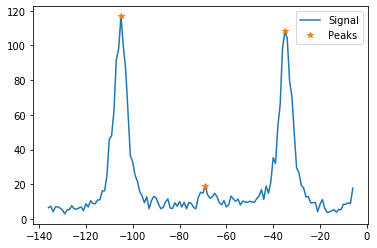

In [4]:
Analyze_Peaks(Data.x, Data.y, 'pix', height = 10, distance = 20, width = 1., verbose = True, fig = True)
#plot(Data.peaks

In [5]:
Data.p0

,Co,Omega,Gamma,Delta,tau,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Initials,1,6.70578,0.626137,0.626137,10.0,0.5,0.1,622.635499,10.851784,16.706945,0.0,19.761224


Cost before fitting = 13420.382954005343
s impiegati a fare il fit  19.490616654 

Cost after fitting = 347.4548276200069

                Co     Omega     Gamma  delta_width  delta_amplitude  \
Values    0.687661  6.865431  0.006670     0.584588         4.656569   
StdErrs   0.527437  0.005611  0.002283     0.029827         2.004545   
Initials  1.000000  6.705780  0.626137     0.626137        10.000000   

                     A            mu          sigma      shift     offset  
Values    4.650461e-01      0.097611     679.449540   9.397712   2.685761  
StdErrs   2.127630e+06  21681.376096  110489.824948   0.005279   0.660973  
Initials  5.000000e-01      0.100000     622.635499  10.851784  16.706945  
Valore stimato della cost function prima del fit totale con fit markoviano:
347.4548276200069


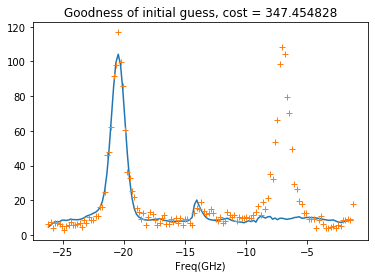

In [6]:
#3) fit markoviano
percents        =   ('positive', 0.2, 'positive', 'positive', 'positive', 0.1, 0.1, 0.1,  np.inf, np.inf)
Data.Get_p0(Data.p0.values[0], cols_mark)
Data.Get_cost_markov(Data.p0.values[0])
print('Cost before fitting = {}'.format(Data.cost_markov))
Data.Get_Fit_Bounds(percents, cols_mark)
Data.Non_Linear_Least_Squares_Markov(bound = (Data.bounds['down'].values, Data.bounds['up'].values),  max_nfev = 100)
Data.Get_cost_markov(Data.Markov_Fit_Params.values[0])
print('Cost after fitting = {}\n'.format(Data.cost_markov))
print(Data.Markov_Fit_Params)
Data.Take_A_Look_Before_Fitting()


In [6]:
#4) fit totale
percents                    =   (0.2, 0.1, 0.1, 'positive', 'positive', 0.15, 0.15, np.inf, np.inf)
Data.Get_Fit_Bounds(percents, columns = cols_real)
p_gauss = Data.Markov_Fit_Params[list(cols_gauss)].values[0]
Data.Get_p0(Data.p0[list(cols_real)].values[0], cols_real)
Data.Non_Linear_Least_Squares(p_gauss, cols_real, bound = (Data.bounds['down'].values, Data.bounds['up'].values), verbose = 2, fig = True, max_nfev = 50)


KeyError: "['tau', 'Delta'] not in index"

In [ ]:
Data.Tot_Fit_Params

In [ ]:
Data.Markov_Fit_Params.T['Values'].values

In [ ]:
np.concatenate((Data.Markov_Fit_Params.T['Values'].values[:3], (Data.p0['Gamma']['Values'], 1.), Data.Markov_Fit_Params.T['Values'].values[3:]))

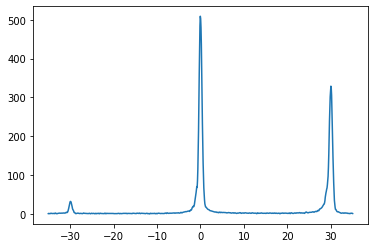

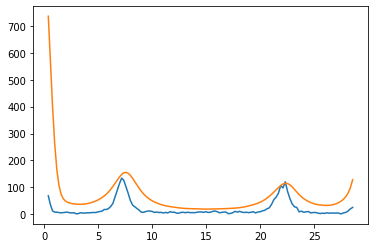

In [20]:
p = np.array([0.1, 7.56805159e+00, 6.19038359e-01, 6.19038359e-01,
       1.00000000e-01, 5.00000000e-01, 1.00000000e+00, 6.22635499e+02,
       0, 1.67069448e+01])

fantoccio = False;(-50, 70)
if fantoccio :

    conv_range = np.linspace(fantoccio[0], fantoccio[1], 200)

else:
    
    conv_range = Data.x_freq

Data.y_markov_convolution      =       np.zeros(conv_range.size)
w_j_VIPA                       =       np.linspace(-35,35, Data.x_VIPA_freq.size)
kernel                         =       Data.Interpolate_VIPA(w_j_VIPA)
plt.figure
plot(w_j_VIPA, kernel)
kernel                         =       kernel/(p[5]*(np.exp(-((w_j_VIPA-p[6])**2)/(2*(p[7]**2)))))

for  ii in range(len(conv_range)):

    delta_w                         =   conv_range[ii] -   w_j_VIPA
    theor                           =   S_Dynamical_Form_Factor_0(delta_w-p[8], *p[0:5])
    Data.y_markov_convolution[ii]   =   np.sum(theor*kernel)
plt.figure()
plot(Data.x_freq, Data.y)

plot(conv_range, Data.y_markov_convolution)

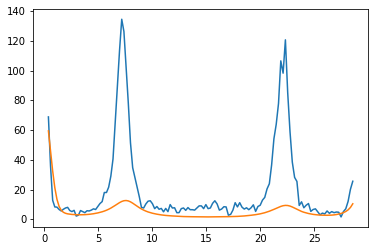

In [21]:
Data.y_markov_convolution      =       np.zeros(Data.x_freq.size)
_ , idx_min             =       Find_Nearest(Data.x_VIPA_freq, -35.)
_ , idx_max             =       Find_Nearest(Data.x_VIPA_freq, 35.)
w_j_VIPA                =       Data.x_VIPA_freq[idx_min:idx_max]#-1 per azzeccare dim coi bins
VIPA_w_j                =       Data.y_VIPA[idx_min:idx_max-1]
Delta_w_j_VIPA          =       Get_Delta_Between_Array_Elements(w_j_VIPA)
w_j_VIPA                =       w_j_VIPA[:w_j_VIPA.size-1]
kernel                  =       VIPA_w_j*Delta_w_j_VIPA/(p[5]*(np.exp(-((w_j_VIPA-p[6])**2)/(2*(p[7]**2)))))

for  ii in range(len(Data.x_freq)):

    delta_w                 =   Data.x_freq[ii] -   w_j_VIPA
    theor                   =   S_Dynamical_Form_Factor_0(delta_w-p[8], *p[0:5])
    Data.y_markov_convolution[ii]  =   np.sum(theor*kernel)

Data.y_Gauss_markov_convolution   =   p[9] + Data.y_markov_convolution*p[5]*np.exp(-((Data.x_freq - p[6])**2)/(2*(p[7]**2)))
plt.figure()
plot(Data.x_freq, Data.y)

plot(Data.x_freq, Data.y_markov_convolution)


In [9]:
p0 = Data.p0.values[0]
Data.Get_p0(p0, cols_mark)
Data.p0.values[0]
Data.p0

,Co,Omega,Gamma,delta_width,delta_amplitude,A,mu,sigma,shift,offset
Values,1.0,7.568052,0.619038,0.619038,10.0,0.5,1.0,622.635499,10.851784,16.706945
